In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tabulate
from functools import reduce
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.src.callbacks import ReduceLROnPlateau 
from keras.src.regularizers import L2

import warnings
warnings.filterwarnings('ignore')

***Retrieving Movies Dataset and Feature Extraction***

In [2]:
movie_data = pd.read_csv("./dataset/movies.csv")
movie_data = movie_data.rename(columns={'movieId': 'id'})
movie_data.head()

,id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
category = []

def get_genre(df):
    genres = df.split('|')
    for i in range(len(genres)):
        if genres[i] not in category:
            category.append(genres[i])

    dict = {}
    dict['genres'] = genres
    return dict

movie_data['genres'] = movie_data['genres'].apply(get_genre)
movie_data.head()

,id,title,genres
0,1,Toy Story (1995),"{'genres': ['Adventure', 'Animation', 'Childre..."
1,2,Jumanji (1995),"{'genres': ['Adventure', 'Children', 'Fantasy']}"
2,3,Grumpier Old Men (1995),"{'genres': ['Comedy', 'Romance']}"
3,4,Waiting to Exhale (1995),"{'genres': ['Comedy', 'Drama', 'Romance']}"
4,5,Father of the Bride Part II (1995),{'genres': ['Comedy']}


In [4]:
def split(df):
    x = df['genres']
    x = str(x).replace("'",'"')
    x = json.loads(x)

    genres = x['genres']
    for item in genres:
        if(item==category[i]):
            return 1
    
    return 0

for i in range(len(category)):
    movie_data[category[i]] = movie_data.apply(split, axis=1)

movie_data = movie_data[movie_data['(no genres listed)'] == 0].drop(columns='(no genres listed)')
movie_data.to_parquet('./dataset/movie_info.parquet', index=False)
movie_data.head()

,id,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
0,1,Toy Story (1995),"{'genres': ['Adventure', 'Animation', 'Childre...",1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"{'genres': ['Adventure', 'Children', 'Fantasy']}",1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"{'genres': ['Comedy', 'Romance']}",0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"{'genres': ['Comedy', 'Drama', 'Romance']}",0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),{'genres': ['Comedy']},0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Retrieving User/Ratings Dataset and Feature Extraction***

In [5]:
ratings = pd.read_csv("./dataset/ratings.csv").drop(columns=['timestamp'])
ratings = ratings.pivot(index='userId', columns='movieId', values='rating')
ratings = ratings.fillna(0)
ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,287633,287707,287711,288135,288167,288209,288265,288269,288311,288563
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)

movieIds = []
for col in ratings.columns:
    movieIds.append(col)

data = {}
user_input = pd.DataFrame(data, index=[])
for user, row in ratings.iterrows():
    row = row.loc[row!=0]
    idx = row.keys()
    user_data = {}
    
    for i in idx:
        movie = movie_data.loc[movie_data['id'] == i]
        rate = row[i]

        if movie.shape[0] == 1:
            movie = list(movie.values[0])
            genres = np.array(movie[3:])
            genres = np.where(genres == 1)[0]

            for k in range(len(genres.tolist())):
                genre = category[genres.tolist()[k]]
                if genre in user_data.keys():
                    user_data[genre].append(rate)
                else:
                    user_data[genre] = []
                    user_data[genre].append(rate)

    for key in user_data.keys():
        user_data[key] = round(average(user_data[key]),2)
        
    index = [user]
    user_input = pd.concat([user_input, pd.DataFrame(user_data, index=index)])

user_input = user_input.fillna(0)
user_input = user_input[['Adventure','Animation','Children','Comedy','Fantasy','Romance','Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','IMAX','Documentary','War','Musical','Western','Film-Noir']]
user_input.reset_index(names='id').to_parquet("./dataset/user_info.parquet")
user_input.head()

***Training/Test Data Generator***

In [ ]:
movie_list = []
user_list = []
y = []

for user, row in ratings.iterrows():
    row = row.loc[row!=0]
    idx = row.keys()
    user_data = {}
    
    for i in idx:
        movie = movie_data.loc[movie_data['id'] == i]
        movie = movie.drop(columns=['id','title','genres'])
        if np.any(movie.to_numpy()):
            movie_list.append(movie.to_numpy())
            user_list.append(user_input.loc[[user]].to_numpy())
            y.append(row[i])

movie_train = np.vstack(movie_list)
user_train = np.vstack(user_list)
movie_train = movie_train[:user_train.shape[0]:]
y_train = np.array(y)

print(movie_train.shape)
print(user_train.shape)
print(y_train.shape)

(525714, 19)
(525714, 19)
(525714,)


In [ ]:
scale_movie = StandardScaler()
scale_movie.fit(movie_train)
movie_train = scale_movie.transform(movie_train)
joblib.dump(scale_movie, "./movie/scale_movie.pkl")

scale_user = StandardScaler()
scale_user.fit(user_train)
user_train = scale_user.transform(user_train)
joblib.dump(scale_user, "./user/scale_user.pkl")

scale_target = MinMaxScaler((-1,1))
scale_target.fit(y_train.reshape(-1,1))
y_train = scale_target.transform(y_train.reshape(-1,1))
joblib.dump(scale_target, "./recommend/scale_target.pkl")

['./recommend/scale_target.pkl']

In [ ]:
movie_train, movie_test = train_test_split(movie_train, train_size=0.80, random_state=42)
user_train, user_test = train_test_split(user_train, train_size=0.80, random_state=42)
y_train, y_test = train_test_split(y_train, train_size=0.80, random_state=42)

***Model Creation, Compilation, Training and Testing***

In [ ]:
@keras.saving.register_keras_serializable()
class L2NormalizationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return tf.linalg.l2_normalize(inputs, axis=1)
    
    def get_config(self):
        return super().get_config()

keras.saving.get_custom_objects()

{'Custom>L2NormalizationLayer': __main__.L2NormalizationLayer}

In [ ]:
num_outputs = 32
tf.random.set_seed(1)
userNN = keras.models.Sequential([
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(num_outputs)
])
movieNN = keras.models.Sequential([
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(num_outputs)
])

user_features = user_train.shape[1]
movie_features = movie_train.shape[1]

input_user = keras.layers.Input(shape=(user_features,))
vu = userNN(input_user)
vu = L2NormalizationLayer()(vu)

input_movie = keras.layers.Input(shape=(movie_features,))
vm = movieNN(input_movie)
vm = L2NormalizationLayer()(vm)

output = keras.layers.Dot(axes=1)([vu,vm])

model = keras.Model([input_user, input_movie], output)
model.summary()

Model: "functional_113"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_65      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_67      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 32)        │     42,144 │ input_layer_65[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 32)        │     42,144 │ input_layer_67[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_normalization_l… │ (None, 32)        │          0 │ sequential_22[0]… │
│ (L2NormalizationLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_normalization_l… │ (None, 32)        │          0 │ sequential_23[0]… │
│ (L2NormalizationLa… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_11 (Dot)        │ (None, 1)         │          0 │ l2_normalization… │
│                     │                   │            │ l2_normalization… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,288 (329.25 KB)

 Trainable params: 84,288 (329.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.random.set_seed(1)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.1))

reduce_lr = ReduceLROnPlateau(monitor = 'loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)
history = model.fit([user_train, movie_train], y_train, epochs=100, batch_size=512, validation_split=0.2, callbacks=[reduce_lr])

Epoch 1/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1855 - val_loss: 0.1707 - learning_rate: 0.1000
Epoch 2/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1693 - val_loss: 0.1658 - learning_rate: 0.1000
Epoch 3/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1642 - val_loss: 0.1645 - learning_rate: 0.1000
Epoch 4/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1632 - val_loss: 0.1637 - learning_rate: 0.1000
Epoch 5/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1615 - val_loss: 0.1605 - learning_rate: 0.1000
Epoch 6/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1590 - val_loss: 0.1599 - learning_rate: 0.1000
Epoch 7/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1584 - val_loss: 0.1597 - learning_rate: 0.1000
Epoch 8/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1581 - val_loss: 0.1593 - learning_rate: 0.1000
Epoch 9/100
658/658 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1572 - val_loss: 0.1572 - learning_rate: 0.1000
E

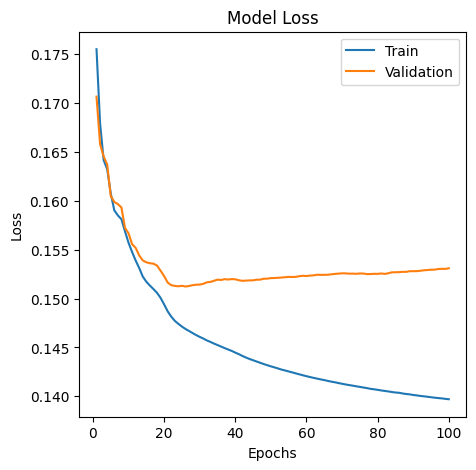

In [ ]:
plt.figure(figsize=(5,5))
model_loss = history.history['loss']
model_val_loss = history.history['val_loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.plot(range(1,len(model_val_loss)+1), model_val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.title("Model Loss")
plt.show()

In [ ]:
model.evaluate([user_test, movie_test], y_test)

3286/3286 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1536


0.1535068303346634

In [ ]:
keras.saving.save_model(model, './recommend/recommend.keras')

In [ ]:
input_movie = keras.layers.Input(shape=(movie_features,))
vm = movieNN(input_movie)
vm = L2NormalizationLayer()(vm)
model_m = tf.keras.Model(input_movie, vm)
model_m.summary()

keras.saving.save_model(model_m, './movie/movie.keras')

Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_69 (InputLayer)     │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ (None, 32)             │        42,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalization_layer_45       │ (None, 32)             │             0 │
│ (L2NormalizationLayer)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,144 (164.62 KB)

 Trainable params: 42,144 (164.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_user = keras.layers.Input(shape=(user_features,))
vu = userNN(input_user)
vu = L2NormalizationLayer()(vu)
model_u = tf.keras.Model(input_user, vu)
model_u.summary()

keras.saving.save_model(model_u, './user/user.keras')

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_22 (Sequential)      │ (None, 32)             │        42,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalization_layer_46       │ (None, 32)             │             0 │
│ (L2NormalizationLayer)          │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,144 (164.62 KB)

 Trainable params: 42,144 (164.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
arr = []
user_np = user_input.reset_index(names=['id']).to_numpy()
user_feat = user_np[:,1:]
user_feat = scale_user.transform(user_feat)
out = model_u.predict(user_feat)

data = []
for i in range(user_np.shape[0]):
    val = [user_np[i,0]]
    val.extend(out[i])

    data.append(val) 

df = pd.DataFrame(data=data)
df = df.rename(columns={0:'id'})
df.to_parquet('./user/user_out.parquet', index=False)
df.head()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,id,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,0.122659,0.011507,0.231752,0.116586,0.143644,-0.115569,-0.131738,0.151735,-0.045723,...,-0.141386,0.402926,-0.141747,-0.086537,-0.344487,-0.013567,0.106509,0.134569,0.180396,-0.000960
1,2.0,0.211837,-0.024267,0.072238,0.359083,-0.037831,-0.096268,-0.256129,-0.039312,0.114412,...,-0.290480,0.157638,0.112055,-0.138639,-0.369767,0.103559,0.123627,0.430317,0.107500,-0.067892
2,3.0,0.045397,-0.062745,0.133370,0.123140,0.027623,-0.152456,-0.108271,0.034113,0.031849,...,-0.097414,0.566925,-0.076448,-0.084014,-0.190708,-0.053877,0.002228,0.134494,0.032685,-0.016145
3,4.0,-0.051047,-0.087326,0.140355,0.099216,0.056448,-0.102779,-0.154168,0.112407,0.020097,...,-0.078756,0.485416,0.053798,-0.168846,-0.199002,-0.094647,-0.052133,0.065115,-0.012652,-0.111620
4,5.0,-0.126251,-0.194758,-0.027417,0.069960,-0.002340,-0.054338,0.073784,-0.253183,-0.239460,...,0.120279,0.134074,0.089855,-0.115958,-0.385718,-0.055381,0.075751,-0.059920,-0.149771,0.081969


In [ ]:
m_data = movie_data.drop(columns=['title','genres'])

arr = []
movie_np = m_data.to_numpy()
movie_feat = movie_np[:,1:]
movie_feat = scale_movie.transform(movie_feat)
out = model_m.predict(movie_feat)

data = []
for i in range(movie_np.shape[0]):
    val = [movie_np[i,0]]
    val.extend(out[i])

    data.append(val) 

df = pd.DataFrame(data=data)
df = df.rename(columns={0:'id'})
df.to_parquet('./movie/movie_out.parquet', index=False)
df.head()

2484/2484 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


,id,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1,0.031418,0.031242,0.440410,0.066864,0.265469,-0.143342,-0.068542,-0.014462,0.251345,...,-0.094953,0.370589,0.126500,-0.039924,-0.245324,-0.139716,-0.047239,0.148003,0.023338,-0.243829
1,2,0.183982,-0.157663,0.419527,-0.021892,0.064217,-0.079610,-0.029196,0.048979,0.106815,...,-0.027595,0.371911,-0.173151,0.043718,-0.033366,-0.240670,-0.092886,0.025471,0.157724,0.138139
2,3,-0.056696,0.055846,0.002221,0.097450,0.061931,-0.029341,-0.047600,-0.035483,0.075290,...,-0.027138,0.387876,0.221420,-0.081520,-0.066424,0.227198,0.135702,0.032676,-0.090262,0.230057
3,4,-0.040337,0.013995,0.033109,0.088484,0.066083,-0.064447,-0.033861,-0.006035,-0.186980,...,-0.023479,0.394512,0.334551,-0.069713,-0.130218,0.126207,0.089424,0.043916,-0.043941,0.149197
4,5,0.032803,0.022860,-0.220445,0.029768,-0.154484,-0.016305,-0.012168,0.020258,0.331806,...,-0.039600,0.470376,0.343322,0.023325,-0.038964,0.110365,0.109779,0.049342,-0.026055,-0.017246


***Compute Similar Movies***

In [ ]:
def dist(a,b):
    return (np.linalg.norm(a-b))**2

In [ ]:
scale_movie = joblib.load('./movie/scale_movie.pkl')
model_m = keras.saving.load_model('./movie/movie.keras')
movie_out = pd.read_parquet('./movie/movie_out.parquet')
movies = pd.read_parquet('./dataset/movie_info.parquet')

In [ ]:
movie_frame = movie_data[movie_data['id'] == 100]
movie_frame.head()

,id,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
98,100,City Hall (1996),"{'genres': ['Drama', 'Thriller']}",0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
input_feat = movie_frame.drop(['genres','id','title'], axis=1)
input_feat = scale_movie.transform(input_feat.to_numpy())
pred = model_m.predict(input_feat)
movie_info = {
    'title': movie_frame['title'].iloc[0],
    'id': movie_frame['id'].iloc[0],
    'genres': movie_frame['genres'].iloc[0],
    'movie_feat': pred[0]
}

print(movie_info)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
{'title': 'City Hall (1996)', 'id': 100, 'genres': {'genres': ['Drama', 'Thriller']}, 'movie_feat': array([ 0.14793701,  0.02682973,  0.0790372 , -0.0243248 , -0.10502418,
       -0.13684635,  0.01970038, -0.07924863, -0.3623189 ,  0.21893696,
       -0.02654199,  0.13620481, -0.55663115,  0.06683769,  0.2944058 ,
       -0.06714161,  0.09966268, -0.08435287,  0.10137267, -0.0225414 ,
        0.04463501,  0.09595054,  0.00252625,  0.48812863, -0.08177312,
        0.1212208 , -0.0446389 , -0.03904511, -0.07905795,  0.06542687,
        0.1258978 , -0.03988737], dtype=float32)}


In [ ]:
similar = np.array([0])

for i in range(1000):
    similar = np.append(similar,[dist(movie_info['movie_feat'], movie_out.to_numpy()[i,1:])])

similar = similar.reshape(-1,1)[1:,:]
similar = movies.to_numpy()[np.argsort(similar[:, 0])]
print(similar)


[[436 'Color of Night (1994)'
  {'genres': array(['Drama', 'Thriller'], dtype=object)} ... 0 0 0]
 [906 'Gaslight (1944)'
  {'genres': array(['Drama', 'Thriller'], dtype=object)} ... 0 0 0]
 [61 'Eye for an Eye (1996)'
  {'genres': array(['Drama', 'Thriller'], dtype=object)} ... 0 0 0]
 ...
 [181 'Mighty Morphin Power Rangers: The Movie (1995)'
  {'genres': array(['Action', 'Children'], dtype=object)} ... 0 0 0]
 [631 'All Dogs Go to Heaven 2 (1996)'
  {'genres': array(['Adventure', 'Animation', 'Children', 'Fantasy', 'Musical',
         'Romance'], dtype=object)}
  ... 1 0 0]
 [546 'Super Mario Bros. (1993)'
  {'genres': array(['Action', 'Adventure', 'Children', 'Comedy', 'Fantasy', 'Sci-Fi'],
        dtype=object)}
  ... 0 0 0]]


In [ ]:
movie_title = movie_info['title']
movie_genre = movie_info['genres']
print(f'Top 5 similar movies to "{movie_title}":\n')
print(f'Genres: {movie_genre}\n')
display = [['Title','Id', 'Genres']]
for i in range(10):
    display.append([similar[i,1], similar[i,0], similar[i,2]])

table = tabulate.tabulate(display, tablefmt='html', headers="firstrow")
table

Top 5 similar movies to "City Hall (1996)":

Genres: {'genres': ['Drama', 'Thriller']}



Title,Id,Genres
Color of Night (1994),436,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Gaslight (1944),906,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Eye for an Eye (1996),61,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Diabolique (1996),640,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Death and the Maiden (1994),229,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Extreme Measures (1996),1003,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Dolores Claiborne (1995),230,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Kalifornia (1993),481,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Butterfly Kiss (1995),696,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"
Some Folks Call It a Sling Blade (1993),678,"{'genres': array(['Drama', 'Thriller'], dtype=object)}"


***Recommend Movies For User***

In [ ]:
scale_user = joblib.load('./user/scale_user.pkl')
scale_target = joblib.load('./recommend/scale_target.pkl')
model_u = keras.saving.load_model('./user/user.keras')
movie_out = pd.read_parquet('./movie/movie_out.parquet')
movie_out.head()

,id,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1,0.031418,0.031242,0.440410,0.066864,0.265469,-0.143342,-0.068542,-0.014462,0.251345,...,-0.094953,0.370589,0.126500,-0.039924,-0.245324,-0.139716,-0.047239,0.148003,0.023338,-0.243829
1,2,0.183982,-0.157663,0.419527,-0.021892,0.064217,-0.079610,-0.029196,0.048979,0.106815,...,-0.027595,0.371911,-0.173151,0.043718,-0.033366,-0.240670,-0.092886,0.025471,0.157724,0.138139
2,3,-0.056696,0.055846,0.002221,0.097450,0.061931,-0.029341,-0.047600,-0.035483,0.075290,...,-0.027138,0.387876,0.221420,-0.081520,-0.066424,0.227198,0.135702,0.032676,-0.090262,0.230057
3,4,-0.040337,0.013995,0.033109,0.088484,0.066083,-0.064447,-0.033861,-0.006035,-0.186980,...,-0.023479,0.394512,0.334551,-0.069713,-0.130218,0.126207,0.089424,0.043916,-0.043941,0.149197
4,5,0.032803,0.022860,-0.220445,0.029768,-0.154484,-0.016305,-0.012168,0.020258,0.331806,...,-0.039600,0.470376,0.343322,0.023325,-0.038964,0.110365,0.109779,0.049342,-0.026055,-0.017246


In [ ]:
Animation = 0.0
Comedy = 0.0
Children = 0.0
Adventure = 5.0
Fantasy = 5.0
Romance = 0.0
Drama = 0.0
Action = 0.0
Crime = 0.0
Thriller = 0.0
Horror = 0.0
IMAX = 0.0
Sci_Fi = 0.0
Mystery = 0.0
War = 0.0
Film_Noir = 0.0
Musical = 0.0
Documentary = 0.0
Western = 0.0

user = np.array([[Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci_Fi,IMAX,Documentary,War,Musical,Western,Film_Noir]])

user = scale_user.transform(user)
user_out = model_u.predict(user)
movies = movie_out.to_numpy()[:,1:]
predictions = np.matmul(movies,user_out.T)
predictions = scale_target.inverse_transform(predictions)
idx  = np.argsort(-predictions[:,0])
print(predictions[idx])
similar = movie_data.to_numpy()[idx]

print(similar)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[4.63277222]
 [4.63277222]
 [4.63277222]
 ...
 [1.66124488]
 [1.62569387]
 [1.62569387]]
[[6743 'Jungle Book (1942)' {'genres': ['Adventure', 'Fantasy']} ... 0 0
  0]
 [135745 'Labyrinth (2012)' {'genres': ['Adventure', 'Fantasy']} ... 0 0
  0]
 [36326 'Strings (2004)' {'genres': ['Adventure', 'Fantasy']} ... 0 0 0]
 ...
 [112640 'Ra.One (2011)' {'genres': ['Action', 'Musical', 'Sci-Fi']} ...
  1 0 0]
 [74404 'Hero: Love Story of a Spy, The (2003)'
  {'genres': ['Action', 'Adventure', 'Drama', 'Musical', 'Romance', 'Thriller', 'War']}
  ... 1 0 0]
 [74406 'Lucky: No Time For Love (2005)'
  {'genres': ['Action', 'Adventure', 'Drama', 'Musical', 'Romance', 'Thriller', 'War']}
  ... 1 0 0]]


In [ ]:
scale_user = joblib.load('./user/scale_user.pkl')
scale_movie = joblib.load('./movie/scale_movie.pkl')
scale_target = joblib.load('./recommend/scale_target.pkl')
movie_info = pd.read_parquet("./dataset/movie_info.parquet")
model = keras.saving.load_model('./recommend/recommend.keras')

In [ ]:
Animation = 0.0
Comedy = 0.0
Children = 0.0
Adventure = 0.0
Fantasy = 0.0
Romance = 0.0
Drama = 5.0
Action = 0.0
Crime = 0.0
Thriller = 5.0
Horror = 0.0
IMAX = 0.0
Sci_Fi = 0.0
Mystery = 0.0
War = 0.0
Film_Noir = 0.0
Musical = 0.0
Documentary = 0.0
Western = 0.0

user = np.array([[Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci_Fi,IMAX,Documentary,War,Musical,Western,Film_Noir]])

movie = movie_info.drop(columns=['id','title','genres']).to_numpy()
movie = scale_movie.transform(movie)
user = np.tile(user, (movie.shape[0],1))
user = scale_user.transform(user)

predictions = model.predict([user,movie])
predictions = scale_target.inverse_transform(predictions)
idx = np.argsort(-predictions[:,0])
predictions = predictions[idx]
print(predictions)
similar = movie_data.to_numpy()[idx]

print(similar)

2484/2484 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
[[4.764467 ]
 [4.7572856]
 [4.7572856]
 ...
 [1.382552 ]
 [1.1738966]
 [1.1738966]]
[[83059 'White Material (2009)'
  {'genres': ['Drama', 'Mystery', 'Thriller', 'War']} ... 0 0 0]
 [163376 'Natural Selection (2016)' {'genres': ['Drama']} ... 0 0 0]
 [59976 'Posto, Il (1961)' {'genres': ['Drama']} ... 0 0 0]
 ...
 [176165 'Cop and a Half: New Recruit (2017)'
  {'genres': ['Action', 'Children', 'Comedy', 'Crime']} ... 0 0 0]
 [144338 'Holiday (2006)'
  {'genres': ['Action', 'Children', 'Comedy', 'Crime', 'Drama', 'Romance']}
  ... 0 0 0]
 [150268 'Dilwale (2015)'
  {'genres': ['Action', 'Children', 'Comedy', 'Crime', 'Drama', 'Romance']}
  ... 0 0 0]]
